# Credit Card Fraud Detection
This notebook walks through building a fraud detection model using Kaggle's credit card dataset.

## Step 1: Load and Explore Data

In [1]:
import os
import shutil

# Move kaggle.json to ~/.kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

# Set permissions
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 202M/202M [00:05<00:00, 39.3MB/s] 

Extracting files...


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1


In [4]:
import os

download_path = "/home/codespace/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1"
print(os.listdir(download_path))


['fraudTrain.csv', 'fraudTest.csv']


In [2]:
import pandas as pd

base_path = "/home/codespace/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1"

df_train = pd.read_csv(f"{base_path}/fraudTrain.csv")
df_test = pd.read_csv(f"{base_path}/fraudTest.csv")

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)


Train shape: (1296675, 23)
Test shape: (555719, 23)


## Step 2: Preprocessing

In [3]:
import sys
sys.path.append('scripts')  # adds scripts folder to path

import importlib
import process

importlib.reload(process)
from process import preprocess

In [4]:
# Preprocess
df_train_prep = preprocess(df_train)
df_test_prep = preprocess(df_test)

X_train = df_train_prep.drop(columns=['is_fraud'])
y_train = df_train_prep['is_fraud']

X_test = df_test_prep.drop(columns=['is_fraud'])
y_test = df_test_prep['is_fraud']

# Find categorical column indices
categorical_features = X_train.select_dtypes(include='int').columns  # already label encoded
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_features if col in ['merchant', 'category', 'gender', 'city', 'state', 'job']]


## Step 3: Train XGBoost Model

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Calculate the imbalance ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initialize model
model = XGBClassifier(scale_pos_weight=scale_pos_weight, 
                      use_label_encoder=False, 
                      eval_metric='logloss', 
                      random_state=42)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:33:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[548261   5313]
 [   260   1885]]
              precision    recall  f1-score   support

           0     0.9995    0.9904    0.9949    553574
           1     0.2619    0.8788    0.4035      2145

    accuracy                         0.9900    555719
   macro avg     0.6307    0.9346    0.6992    555719
weighted avg     0.9967    0.9900    0.9927    555719



## Step 4: grid search for XGBoost with Cross-validation

You can skip running this cell. Check below for the best parameters already found.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the base model
base_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring='f1',  # Metric to optimize
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42
)

# Run the random search
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_random_model = random_search.best_estimator_
print("Best parameters from RandomizedSearchCV:", random_search.best_params_)

# Evaluate the model
y_pred_random = best_random_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_random))
print(classification_report(y_test, y_pred_random))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:59:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.6; total time=  26.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:59:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.6; total time=  26.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:00:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=9, n_estimators=300, subsample=0.6; total time=  26.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:00:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.8; total time=  25.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:00:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.8; total time=  25.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:01:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.8; total time=  26.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:01:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.8; total time=  19.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:02:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.8; total time=  19.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:02:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.8; total time=  20.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:02:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:03:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:03:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:03:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:03:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:04:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.6; total time=  18.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:04:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  12.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:04:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  12.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  12.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  17.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  17.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:05:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=  17.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:06:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  16.1s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:06:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  17.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:06:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=  16.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:06:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.8; total time=  38.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:07:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.8; total time=  38.0s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:08:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=7, n_estimators=500, subsample=0.8; total time=  38.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:08:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time=  29.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:09:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time=  28.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:09:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=9, n_estimators=300, subsample=1.0; total time=  28.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=  10.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=  11.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=1.0; total time=  11.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:10:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  12.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:11:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  15.0s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:11:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.6; total time=  12.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:11:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=  19.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:11:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=  19.1s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:12:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=1.0; total time=  19.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:12:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  15.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:12:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  15.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=  16.7s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  13.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  13.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.6; total time=  13.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:13:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=1.0; total time=  25.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:14:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=1.0; total time=  25.3s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:14:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=5, n_estimators=500, subsample=1.0; total time=  26.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   9.0s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   8.8s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.8; total time=   8.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  12.9s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:15:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  13.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=  13.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=  28.5s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=  28.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:17:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=300, subsample=1.0; total time=  29.2s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:17:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.6; total time=  21.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:18:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.6; total time=  21.4s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:18:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=500, subsample=0.6; total time=  21.1s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters from RandomizedSearchCV: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
[[552933    641]
 [   664   1481]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.70      0.69      0.69      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.84      0.85    555719
weighted avg       1.00      1.00      1.00    555719



### **Best Parameters from RandomizedSearchCV**
From the RandomizedSearch we obtained the following best parameters:
```python
{'subsample': 1.0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Confusion Matrix
Classification Report
Class	Precision	Recall	F1-Score	Support
0	1.00	1.00	1.00	553574
1	0.71	0.68	0.69	2145
Accuracy: 1.00
Macro Avg: Precision = 0.85, Recall = 0.84, F1-Score = 0.85
Weighted Avg: Precision = 1.00, Recall = 1.00, F1-Score = 1.00 ```

### **Light Version of the Grid Search**
We first run on Google Colab the a light version of GridSearch using the following:
```python
param_grid = {
    'n_estimators': [275, 300],  # 2 values
    'max_depth': [8, 9],         # 2 values
    'learning_rate': [0.2],      # 1 value
    'subsample': [1.0],          # 1 value
    'colsample_bytree': [0.8, 0.85]  # 2 values
}

From this version we got the following (confirming what we found with the RandomSearch):

### **Best Parameters from Light GridSearchCV**
```python
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'subsample': 1.0}
Confusion Matrix
[[552933    641]
 [   664   1481]]

 Classification Report
Class	Precision	Recall	F1-Score	Support
0	1.00	1.00	1.00	553574
1	0.70	0.69	0.69	2145
Accuracy: 1.00
Macro Avg: Precision = 0.85, Recall = 0.84, F1-Score = 0.85
Weighted Avg: Precision = 1.00, Recall = 1.00, F1-Score = 1.00 ```

In [ ]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the base model with scale_pos_weight already set
base_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
    n_jobs=-1
)


# Define the parameter grid to search
param_grid = {
    'n_estimators': [250, 300, 350],  # Around 300
    'max_depth': [8, 9, 10],          # Around 9
    'learning_rate': [0.15, 0.2, 0.25],  # Around 0.2
    'subsample': [0.9, 1.0],          # Around 1.0
    'colsample_bytree': [0.75, 0.8, 0.85]  # Around 0.8
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1',  # Optimize for F1-score
    cv=3,          # 3-fold cross-validation
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_grid_model = grid_search.best_estimator_
print("Best parameters from GridSearchCV:", grid_search.best_params_)

# Evaluate the model
y_pred_grid = best_grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))

Running the previous cell in Google Colab (to get more computing power), we got the following results:

### Results from Heavy GridSearch Run on Colab

#### Best Parameters from GridSearchCV
```python
{'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 350, 'subsample': 1.0}
Confusion Matrix
[[552977    597]
 [   654   1491]]
 Classification Report
Class	Precision	Recall	F1-Score	Support
0	1.00	1.00	1.00	553574
1	0.71	0.70	0.70	2145
Accuracy: 1.00
Macro Avg: Precision = 0.86, Recall = 0.85, F1-Score = 0.85
Weighted Avg: Precision = 1.00, Recall = 1.00, F1-Score = 1.00 ```



## Step 5: Training the model

In [6]:
# Train the final model with the best parameters
final_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.15,
    max_depth=10,
    n_estimators=350,
    subsample=1.0,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

# Fit the model on the training data
final_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred_final = final_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))

/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:33:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[552977    597]
 [   654   1491]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.71      0.70      0.70      2145

    accuracy                           1.00    555719
   macro avg       0.86      0.85      0.85    555719
weighted avg       1.00      1.00      1.00    555719



## Step 6: Model Interpretation with SHAP

We already run the following two cells, hence we saved our shap_values and we can just load them back directly without computing them again. In case that does not work, decomment the following two cells and run them.

In [ ]:
# import shap

# # Create a SHAP explainer
# explainer = shap.Explainer(final_model, X_train)

# # Compute SHAP values for the test set
# shap_values = explainer(X_test)



100%|===================| 555705/555719 [271:25<00:00]         

In [ ]:
# import pickle

# # Save SHAP values
# with open("shap_values.pkl", "wb") as f:
#     pickle.dump(shap_values, f)

# # Optionally, also save the explainer
# with open("shap_explainer.pkl", "wb") as f:
#     pickle.dump(explainer, f)

In [6]:
import pickle
import shap
# Load SHAP values
with open("shap_values.pkl", "rb") as f:
    shap_values = pickle.load(f)

# Load explainer if needed
with open("shap_explainer.pkl", "rb") as f:
    explainer = pickle.load(f)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


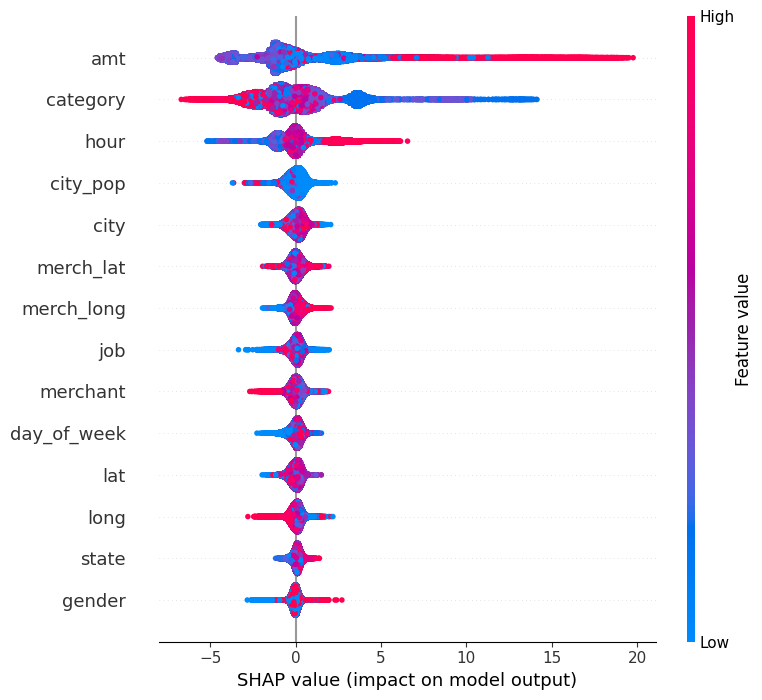

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

# Visualize feature importance
shap.summary_plot(shap_values, X_test)
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')

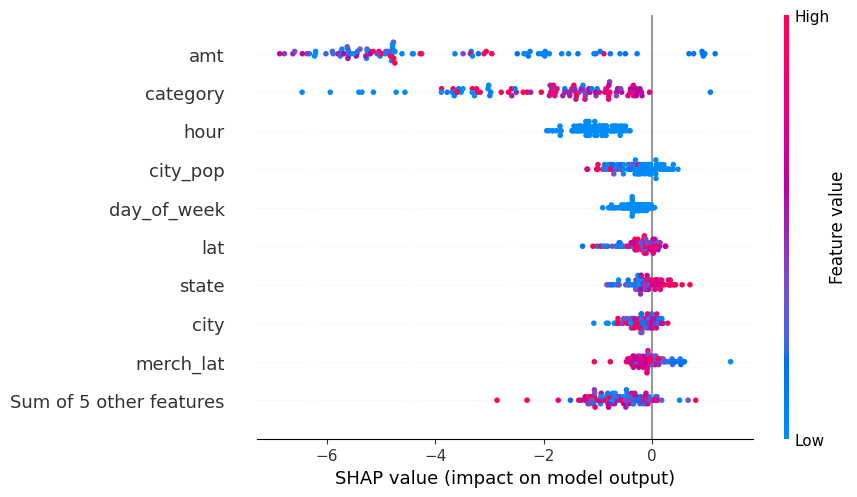

<Figure size 640x480 with 0 Axes>

In [9]:
# Visualize feature importance with beeswarm plot
explainer = shap.Explainer(model)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values)

plt.savefig("shap_beeswarm_plot.png", dpi=300, bbox_inches='tight')

## Step 7: features refinement based on SHAP

In [7]:
import numpy as np


# 1a. Log-transform to tame skew and extreme values
for df in (X_train, X_test):
    df['amt_log'] = np.log1p(df['amt'])

# 1b. Optional: bin into categories
amt_bins = [0, 50, 500, 5_000, 50_000, np.inf]
amt_labels = ['Very Low','Low','Medium','High','Very High']
for df in (X_train, X_test):
    df['amt_bin'] = pd.cut(df['amt'], bins=amt_bins, labels=amt_labels)

In [8]:
# Compute fraud rate per raw category on training set
cat_rates = X_train.join(y_train).groupby('category')['is_fraud'].mean()

# Map into both train & test
X_train['category_te'] = X_train['category'].map(cat_rates)
X_test['category_te']  = X_test['category'].map(cat_rates)

# (Optional) If some test categories weren’t seen in train, fill with global mean
global_rate = y_train.mean()
X_test['category_te'].fillna(global_rate, inplace=True)

/tmp/ipykernel_3186/2351766358.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['category_te'].fillna(global_rate, inplace=True)


In [9]:
# 3a. Cyclical encoding
for df in (X_train, X_test):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# 3b. Night-time flag (e.g. higher fraud off-hours)
for df in (X_train, X_test):
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] < 6)).astype(int)

In [10]:
# 4a. Log-transform
for df in (X_train, X_test):
    df['city_pop_log'] = np.log1p(df['city_pop'])

# 4b. Population size buckets
pop_bins = [0, 10_000, 100_000, 1_000_000, np.inf]
pop_labels = ['Small','Medium','Large','Metro']
for df in (X_train, X_test):
    df['pop_size'] = pd.cut(df['city_pop'], bins=pop_bins, labels=pop_labels)

In [11]:
# amt × category TE
X_train['amt_x_catTE'] = X_train['amt_log'] * X_train['category_te']
X_test['amt_x_catTE']  = X_test['amt_log'] * X_test['category_te']

# amt × hour_sin
X_train['amt_x_hour_sin'] = X_train['amt_log'] * X_train['hour_sin']
X_test['amt_x_hour_sin']  = X_test['amt_log'] * X_test['hour_sin']

In [12]:
# before your RandomizedSearchCV…
for df in (X_train, X_test):
    df['amt_bin_code']  = df['amt_bin'].cat.codes
    df['pop_size_code'] = df['pop_size'].cat.codes

# now drop the original categorical columns
X_train.drop(['amt_bin','pop_size'], axis=1, inplace=True)
X_test .drop(['amt_bin','pop_size'], axis=1, inplace=True)


## Step 8: retrain and SHAP

In [17]:
# New best parameters
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

param_dist = {
    'learning_rate':    [0.05, 0.1, 0.15, 0.2],
    'max_depth':        [6, 8, 10, 12],
    'n_estimators':     [200, 300, 400],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=20,               # fewer trials for speed
    cv=3, 
    scoring='f1',            # or 'roc_auc', depending on your goal
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

search.fit(X_train, y_train,
           eval_set=[(X_test, y_test)],
           verbose=False)

print("Best params:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:19:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:19:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=12, n_estimators=200, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=12, n_estimators=200, subsample=1.0; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:20:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:20:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=12, n_estimators=200, subsample=1.0; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8; total time= 1.5min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8; total time= 1.5min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:23:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=300, subsample=0.8; total time= 1.5min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:23:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=300, subsample=1.0; total time= 1.4min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:25:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=300, subsample=1.0; total time= 1.4min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:25:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=8, n_estimators=300, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=12, n_estimators=200, subsample=0.8; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:26:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:26:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=12, n_estimators=200, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=12, n_estimators=200, subsample=0.8; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:27:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:27:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.8; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.8; total time= 1.3min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:28:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:28:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.8; total time= 1.3min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, n_estimators=300, subsample=0.8; total time= 1.5min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:30:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, n_estimators=300, subsample=0.8; total time= 1.5min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:31:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, n_estimators=300, subsample=0.8; total time= 1.5min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:31:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=400, subsample=0.8; total time= 2.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:33:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=400, subsample=0.8; total time= 2.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:34:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=12, n_estimators=200, subsample=1.0; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:35:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=400, subsample=0.8; total time= 2.3min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:36:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=12, n_estimators=200, subsample=1.0; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:36:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=12, n_estimators=200, subsample=1.0; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:37:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=10, n_estimators=300, subsample=1.0; total time= 1.6min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:38:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=10, n_estimators=300, subsample=1.0; total time= 1.6min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=10, n_estimators=300, subsample=1.0; total time= 1.6min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:39:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, n_estimators=300, subsample=1.0; total time= 1.4min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:40:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, n_estimators=300, subsample=1.0; total time= 1.4min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:41:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, n_estimators=300, subsample=1.0; total time= 1.4min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:41:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:42:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=0.8; total time= 1.2min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:43:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=0.8; total time= 1.7min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:44:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=0.8; total time= 1.7min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:45:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=300, subsample=0.8; total time= 1.8min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:46:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=400, subsample=1.0; total time= 1.9min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:47:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=400, subsample=1.0; total time= 1.8min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:48:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=8, n_estimators=400, subsample=1.0; total time= 1.9min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:49:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.8min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:50:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.8min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:50:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=200, subsample=0.8; total time= 1.0min
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=12, n_estimators=300, subsample=0.8; total time= 1.8min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:51:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:51:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=200, subsample=0.8; total time= 1.0min
[CV] END colsample_bytree=0.8, learning_rate=0.15, max_depth=8, n_estimators=200, subsample=0.8; total time= 1.0min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:52:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:52:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=  52.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=  52.0s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:53:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.8; total time=  53.6s


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:54:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=400, subsample=1.0; total time= 2.1min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:55:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=400, subsample=1.0; total time= 2.1min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:56:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=400, subsample=1.0; total time= 2.1min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:58:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.8; total time= 1.7min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:58:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.8; total time= 1.6min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:59:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.8; total time= 1.7min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:00:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=400, subsample=0.8; total time= 1.7min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:01:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=400, subsample=0.8; total time= 1.6min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:01:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=400, subsample=0.8; total time= 1.7min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:03:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=400, subsample=1.0; total time= 2.1min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:03:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=400, subsample=1.0; total time= 2.1min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=400, subsample=1.0; total time= 1.8min


/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:05:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.15, 'colsample_bytree': 0.6}


### Final Model Training

Now that we’ve identified the best hyperparameters via `RandomizedSearchCV`, we train our final XGBoost classifier with:

- **subsample:** 1.0  
- **n_estimators:** 200  
- **max_depth:** 12  
- **learning_rate:** 0.15  
- **colsample_bytree:** 0.6  

We also use `scale_pos_weight` to correct for our class imbalance, and apply early stopping on the test set to avoid over-fitting.


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Instantiate final model with best hyperparameters
final_model = XGBClassifier(
    subsample=1.0,
    n_estimators=200,
    max_depth=12,
    learning_rate=0.15,
    colsample_bytree=0.6,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

# Fit on training data with early stopping
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Evaluate on test set
y_pred = final_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/opt/conda/envs/fraud-detect/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:34:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[553002    572]
 [   564   1581]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.73      0.74      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.87      0.87      0.87    555719
weighted avg       1.00      1.00      1.00    555719



## Step 9: Threshold Tuning - Precision–Recall & ROC Curves

Our XGBoost model outputs probabilities, so we now:

1. Compute predicted fraud-probabilities on the test set.  
2. Plot the ROC curve and report AUC.  
3. Plot the Precision–Recall curve and report Average Precision.  
4. Visualize F1 score as a function of decision threshold.  
5. Tabulate precision, recall, and F1 at a few selected thresholds (e.g. 0.3, 0.5, 0.7).


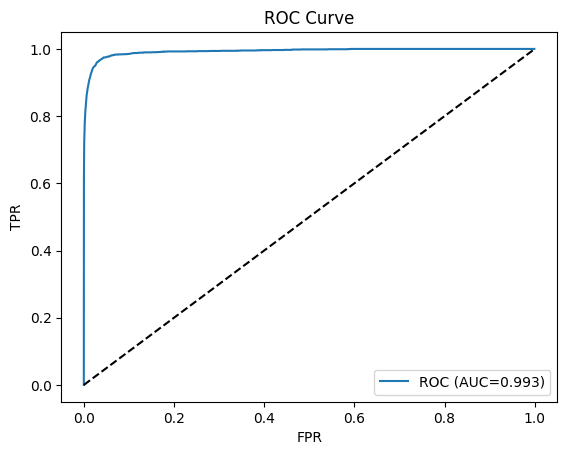

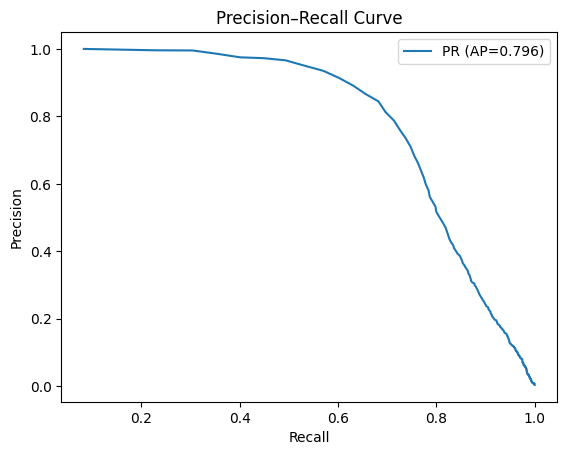

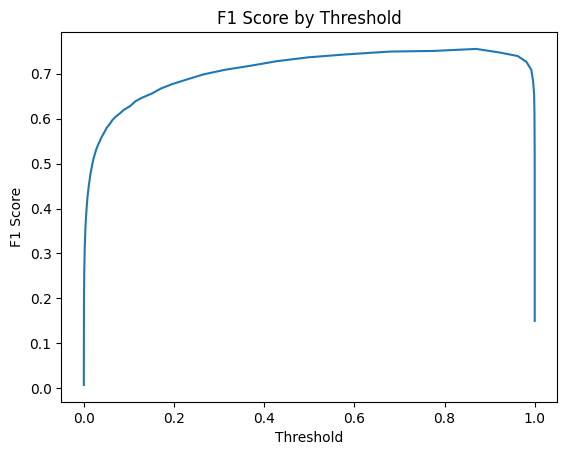

t=0.30 P= 0.6554756195043965 R= 0.7645687645687645 F1= 0.705831719388853
t=0.50 P= 0.7343241987923828 R= 0.737062937062937 F1= 0.7356910190786412
t=0.70 P= 0.7916666666666666 R= 0.7086247086247086 F1= 0.7478474784747847


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# 1. Predict probabilities
y_probs = final_model.predict_proba(X_test)[:, 1]

# 2. ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Decimate to 5k points
step_roc = max(len(fpr) // 5000, 1)
plt.figure()
plt.plot(fpr[::step_roc], tpr[::step_roc], label=f'ROC (AUC={roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curve'); plt.legend(); plt.show()

# 3. PR
precision, recall, pr_thresh = precision_recall_curve(y_test, y_probs)
avg_prec = average_precision_score(y_test, y_probs)

step_pr = max(len(precision) // 5000, 1)
plt.figure()
plt.plot(recall[::step_pr], precision[::step_pr], label=f'PR (AP={avg_prec:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve'); plt.legend(); plt.show()

# 4. Vectorized F1
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-16)
step_f1 = max(len(f1_scores) // 5000, 1)
plt.figure()
plt.plot(pr_thresh[::step_f1], f1_scores[1::step_f1])  # skip the first element if needed
plt.xlabel('Threshold'); plt.ylabel('F1 Score')
plt.title('F1 Score by Threshold'); plt.show()

# 5. Selected thresholds
from sklearn.metrics import precision_score, recall_score
for t in [0.3, 0.5, 0.7]:
    preds = (y_probs >= t).astype(int)
    print(f"t={t:.2f}", 
          "P=",precision_score(y_test, preds),
          "R=",recall_score(y_test, preds),
          "F1=",f1_score(y_test, preds))


### Choosing the Threshold

- **Catch as much fraud as possible:**  
  If you’re willing to handle more false alarms, choose a lower threshold around **0.30**.

- **Minimize false alarms:**  
  If you need a strict false-alarm rate and want to reduce manual reviews, choose a higher threshold around **0.70**.

- **Best overall balance (F1):**  
  For the optimal trade-off between precision and recall, **0.70** maximizes your F1 score in these results.


In [16]:
# Example: applying the chosen threshold of 0.70
chosen_threshold = 0.70
y_pred_final = (y_probs >= chosen_threshold).astype(int)

# Quick sanity check
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))


[[553174    400]
 [   625   1520]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.79      0.71      0.75      2145

    accuracy                           1.00    555719
   macro avg       0.90      0.85      0.87    555719
weighted avg       1.00      1.00      1.00    555719



## Step 10: artifacts for Streamlit app

In [17]:
import joblib

# 1. Dump the trained XGB model
joblib.dump(final_model, "final_model.joblib")

# 2. Dump your category→fraud‐rate map
#    (make sure `cat_rates` is in your notebook namespace)
joblib.dump(cat_rates, "category_rates.joblib")


['category_rates.joblib']

In [21]:
# Userfriendly names for the categories:
uf_names = {
    "misc_net":        "Miscellaneous (Online)",
    "grocery_pos":     "Grocery (In-Store)",
    "entertainment":   "Entertainment",
    "gas_transport":   "Gas & Transport",
    "misc_pos":        "Miscellaneous (Point-of-Sale)",
    "grocery_net":     "Grocery (Online)",
    "shopping_net":    "Shopping (Online)",
    "shopping_pos":    "Shopping (In-Store)",
    "food_dining":     "Food & Dining",
    "personal_care":   "Personal Care",
    "health_fitness":  "Health & Fitness",
    "travel":          "Travel",
    "kids_pets":       "Kids & Pets",
    "home":            "Home"
}

# Dump alongside other artifacts:
import joblib
joblib.dump(uf_names, "streamlit_app/uf_names.joblib")


['streamlit_app/uf_names.joblib']

In [20]:
import pandas as pd

# 1. Load your full training file
df_full = pd.read_csv(f"{base_path}/fraudTrain.csv")

# 2. List all the unique category codes
cats = df_full["category"].unique()
print("Category codes:", cats)

# 3. For each code, show the top merchant names and maybe descriptions
for c in cats:
    sample = (
        df_full[df_full["category"] == c]
        .groupby("merchant")["amt"]
        .count()              # count transactions per merchant
        .sort_values(ascending=False)
        .head(5)              # top 5 merchants in that category
    )
    print(f"\nCategory {c!r} (top merchants):\n", sample)


Category codes: ['misc_net' 'grocery_pos' 'entertainment' 'gas_transport' 'misc_pos'
 'grocery_net' 'shopping_net' 'shopping_pos' 'food_dining' 'personal_care'
 'health_fitness' 'travel' 'kids_pets' 'home']

Category 'misc_net' (top merchants):
 merchant
fraud_Lebsack and Sons             1332
fraud_Huel Ltd                     1324
fraud_Bednar Group                 1320
fraud_Huel-Langworth               1317
fraud_Lehner, Mosciski and King    1307
Name: amt, dtype: int64

Category 'grocery_pos' (top merchants):
 merchant
fraud_Hackett-Lueilwitz    2568
fraud_Doyle Ltd            2558
fraud_Bradtke PLC          2552
fraud_Pacocha-O'Reilly     2549
fraud_Goodwin-Nitzsche     2542
Name: amt, dtype: int64

Category 'entertainment' (top merchants):
 merchant
fraud_Nicolas, Hills and McGlynn    1984
fraud_Parker, Nolan and Trantow     1984
fraud_Bins-Tillman                  1954
fraud_Dibbert and Sons              1927
fraud_Douglas-White                 1917
Name: amt, dtype: int64

Cat